In [3]:
#input尝试三种，一个是mfcc图像，一个是vggish输出的特征值，还有一个是opensmile输出的特征值
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display

In [1]:
import opensmile
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# 初始化 OpenSMILE
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

# 函数：使用 OpenSMILE 提取特征并保存为 .npy 文件
def extract_opensmile_features(file_path, output_dir):
    features = smile.process_file(file_path)
    feature_file_name = os.path.basename(file_path).replace('.wav', '.npy')
    output_file_path = os.path.join(output_dir, feature_file_name)
    np.save(output_file_path, features.values)

# 处理并保存 OpenSMILE 特征
def process_folder_and_save_opensmile(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(input_dir, filename)
            extract_opensmile_features(file_path, output_dir)

# 定义要处理的文件夹和类别
folders = ['breathing', 'cough', 'count']
categories = ['negative', 'positive']

# 遍历每个文件夹和类别，处理并保存 OpenSMILE 特征
for folder in folders:
    for category in categories:
        input_folder = os.path.join('训练集', folder, category)
        output_folder = os.path.join('训练集', 'opensmile_features', folder, category)
        process_folder_and_save_opensmile(input_folder, output_folder)


In [ ]:
#加载数据

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_features_and_labels(root_dir, folders, categories):
    features = []
    labels = []
    for folder in folders:
        for category in categories:
            label = categories.index(category)
            folder_path = os.path.join(root_dir, folder, category)
            for filename in os.listdir(folder_path):
                if filename.endswith('.npy'):
                    feature_path = os.path.join(folder_path, filename)
                    feature = np.load(feature_path)
                    features.append(feature)
                    labels.append(label)
    return np.array(features), np.array(labels)

# 加载数据
folders = ['breathing', 'cough', 'count']
categories = ['negative', 'positive']
root_dir = '训练集/vggish_features'
# 加载数据
X, y = load_features_and_labels('训练集/opensmile_features', folders, categories)
X = np.squeeze(X, axis=1)
# 拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [9]:
X.shape

(3043, 6373)

In [ ]:
#训练模型-随机森林

Accuracy: 0.7964


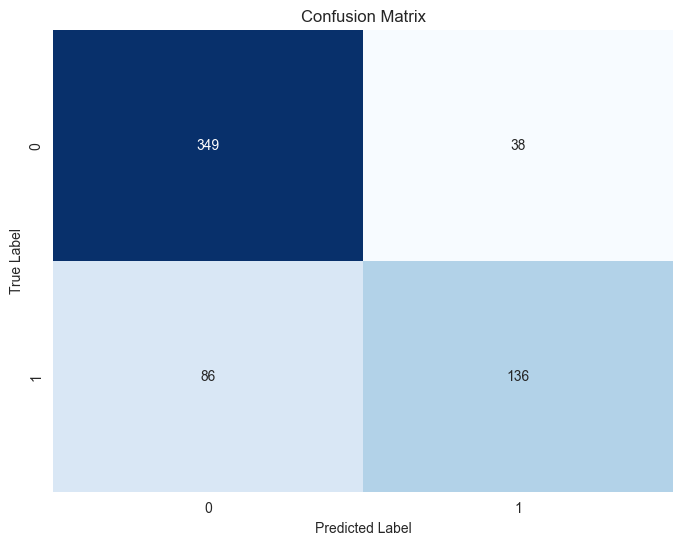

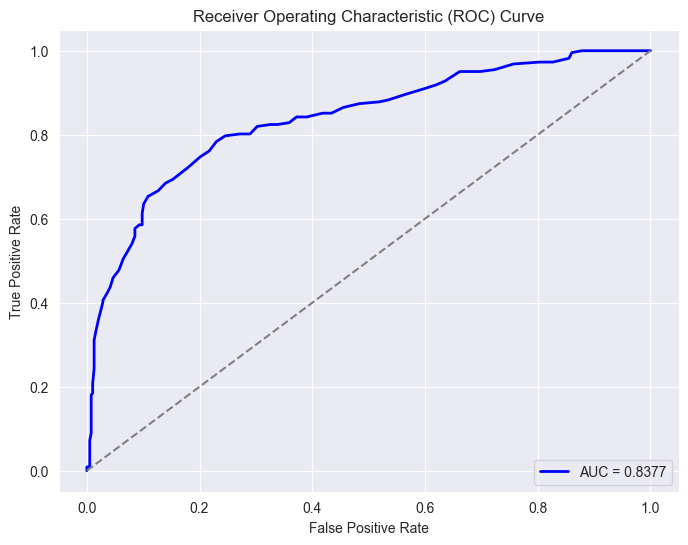

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 初始化分类器
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# 训练分类器
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# 预测
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))

# 评估
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 预测
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 计算AUC
# 如果是二分类问题，直接计算AUC
if len(categories) == 2:
    y_pred_proba = clf.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

else:
    # 对于多分类问题，需要进行二值化处理
    y_test_bin = label_binarize(y_test, classes=range(len(categories)))
    y_pred_proba = clf.predict_proba(X_test.reshape(X_test.shape[0], -1))
    
    # 计算每个类别的AUC，并求平均值
    auc_scores = []
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {auc_score:.4f}')
    
    mean_auc = np.mean(auc_scores)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Mean AUC = {mean_auc:.4f})')
    plt.legend(loc='lower right')
    plt.show()

    print(f'Mean AUC: {mean_auc:.4f}')


Accuracy: 0.8062


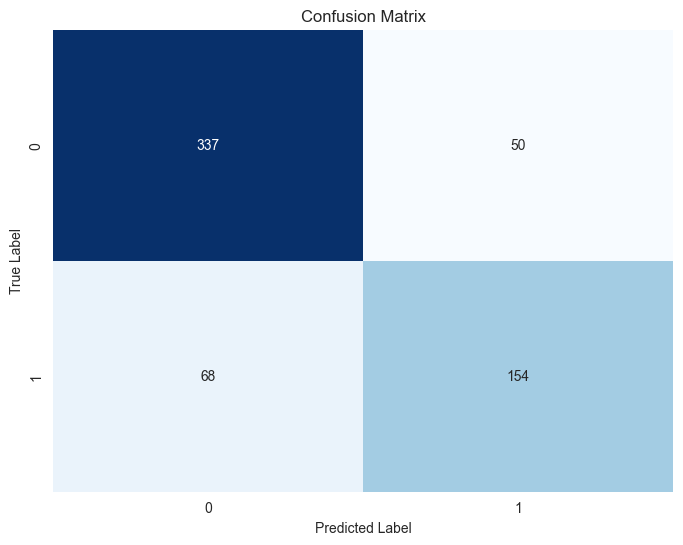

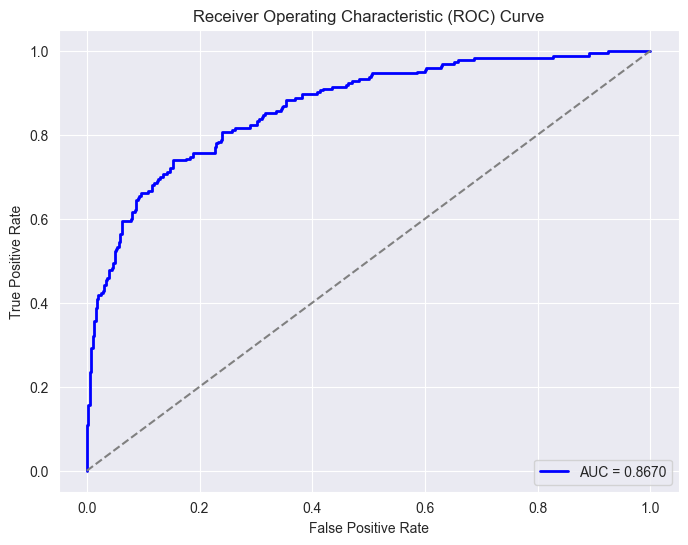

In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化 XGBoost 分类器
clf = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# 训练分类器
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# 预测
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))

# 评估
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 计算AUC
# 如果是二分类问题，直接计算AUC
if len(categories) == 2:
    y_pred_proba = clf.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

else:
    # 对于多分类问题，需要进行二值化处理
    y_test_bin = label_binarize(y_test, classes=range(len(categories)))
    y_pred_proba = clf.predict_proba(X_test.reshape(X_test.shape[0], -1))
    
    # 计算每个类别的AUC，并求平均值
    auc_scores = []
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {auc_score:.4f}')
    
    mean_auc = np.mean(auc_scores)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Mean AUC = {mean_auc:.4f})')
    plt.legend(loc='lower right')
    plt.show()

    print(f'Mean AUC: {mean_auc:.4f}')


In [12]:
#训练模型-深度学习

Epoch 1/20, Loss: 0.0403
Epoch 2/20, Loss: 0.0610
Epoch 3/20, Loss: 0.0591
Epoch 4/20, Loss: 0.1215
Epoch 5/20, Loss: 0.2266
Epoch 6/20, Loss: 0.0089
Epoch 7/20, Loss: 0.0071
Epoch 8/20, Loss: 0.0160
Epoch 9/20, Loss: 0.0435
Epoch 10/20, Loss: 0.1490
Epoch 11/20, Loss: 0.0006
Epoch 12/20, Loss: 0.0011
Epoch 13/20, Loss: 0.0145
Epoch 14/20, Loss: 0.0002
Epoch 15/20, Loss: 0.0026
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Accuracy: 79.97%


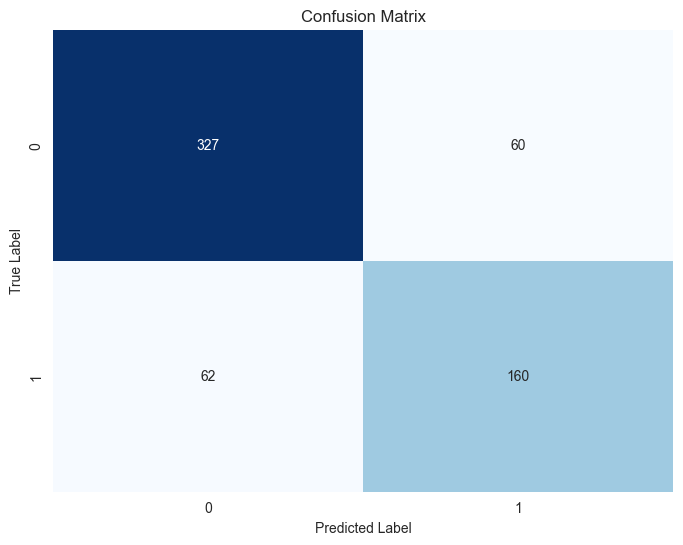

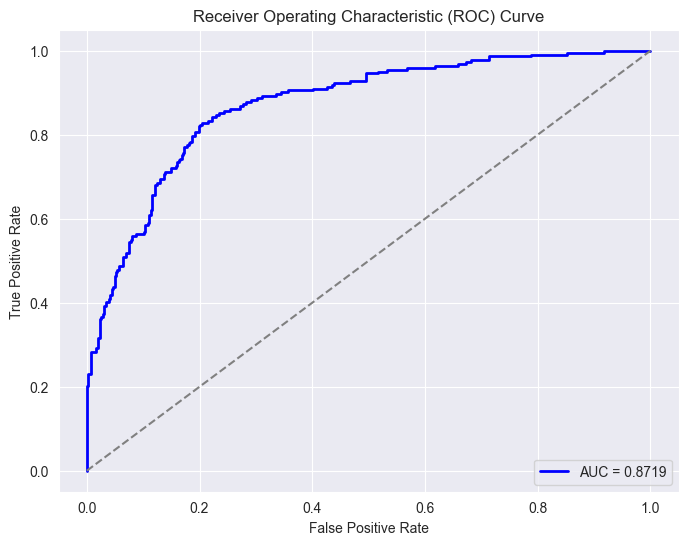

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
# 准备数据
# 对训练集进行标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# 对测试集使用相同的标准化器进行转换
X_test = scaler.transform(X_test)

# 将标准化后的数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建数据集和数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定义简单的神经网络
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 初始化模型
input_size = X_train.shape[1]  # 这里是 128
num_classes = len(categories)
model = SimpleNN(input_size, num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# 测试模型
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
all_probas = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        probas = torch.softmax(outputs, dim=1)  # 获取每个类别的预测概率
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probas.extend(probas.cpu().numpy())  # 收集每个样本的概率

print(f'Accuracy: {100 * correct / total:.2f}%')

# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 计算并绘制AUC
if num_classes == 2:
    y_pred_proba = np.array(all_probas)[:, 1]  # 取正类（类1）的概率
    auc_score = roc_auc_score(all_labels, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(all_labels, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

else:
    y_test_bin = label_binarize(all_labels, classes=range(num_classes))
    y_pred_proba = np.array(all_probas)
    
    auc_scores = []
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} AUC = {auc_score:.4f}')
    
    mean_auc = np.mean(auc_scores)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Mean AUC = {mean_auc:.4f})')
    plt.legend(loc='lower right')
    plt.show()

    print(f'Mean AUC: {mean_auc:.4f}')
